In [1]:
import multiprocessing
import sys
from pettingzoo.test import parallel_api_test
from citylearn import GridLearn
from citylearn import MyEnv
from pathlib import Path
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3 import PPO
import gym
import numpy as np
import supersuit as ss

import time

# multiprocessing.set_start_method("fork")

climate_zone = 1
data_path = Path("../citylearn/data/Climate_Zone_"+str(climate_zone))
buildings_states_actions = '../citylearn/buildings_state_action_space.json'

config = {
    "model_name":"small_test",
    "data_path":data_path,
    "climate_zone":climate_zone,
    "buildings_states_actions_file":buildings_states_actions,
    "hourly_timesteps":4,
#     "percent_rl":0.1,
    "percent_rl":1,
    "nclusters":2,
#     "max_num_houses":None
    "max_num_houses":4
}

grid = GridLearn(**config)

envs = [MyEnv(grid) for _ in range(config['nclusters'])]

print('padding action/observation spaces...')
envs = [ss.pad_action_space_v0(env) for env in envs]
envs = [ss.pad_observations_v0(env) for env in envs]

print('creating pettingzoo env...')
envs = [ss.pettingzoo_env_to_vec_env_v0(env) for env in envs]

print('stacking vec env...')
nenvs = 2
envs = [ss.concat_vec_envs_v0(env, nenvs, num_cpus=1, base_class='stable_baselines3') for env in envs]


/Users/aislingpigott/Documents/CityLearn/citylearn/energy_models.py:552: RuntimeWarning: divide by zero encountered in true_divide
  self.cooling_device.cop_cooling = self.cooling_device.eta_tech*(np.add(self.cooling_device.t_target_cooling,273.15))/np.subtract(self.sim_results['t_out'],self.cooling_device.t_target_cooling)
/Users/aislingpigott/Documents/CityLearn/citylearn/energy_models.py:552: RuntimeWarning: divide by zero encountered in true_divide
  self.cooling_device.cop_cooling = self.cooling_device.eta_tech*(np.add(self.cooling_device.t_target_cooling,273.15))/np.subtract(self.sim_results['t_out'],self.cooling_device.t_target_cooling)
/Users/aislingpigott/Documents/CityLearn/citylearn/energy_models.py:552: RuntimeWarning: divide by zero encountered in true_divide
  self.cooling_device.cop_cooling = self.cooling_device.eta_tech*(np.add(self.cooling_device.t_target_cooling,273.15))/np.subtract(self.sim_results['t_out'],self.cooling_device.t_target_cooling)
/Users/aislingpigott/D

padding action/observation spaces...
creating pettingzoo env...
stacking vec env...


In [2]:
from copy import deepcopy
grid2 = deepcopy(grid)

In [3]:
grids = [grid, grid2]

In [4]:
print('setting the grid...')
for env in envs:
    for n in range(nenvs):
        env.venv.vec_envs[n].par_env.aec_env.env.env.env.env.grid = grids[n]
        env.venv.vec_envs[n].par_env.aec_env.env.env.env.env.initialize_rbc_agents()

setting the grid...


In [5]:
models = [PPO(MlpPolicy, env, verbose=2, gamma=0.999, batch_size=2, n_steps=1, ent_coef=0.01, learning_rate=0.00025, vf_coef=0.5, max_grad_norm=0.5, gae_lambda=0.95, n_epochs=4, clip_range=0.2, clip_range_vf=1) for env in envs]

Using cpu device
Using cpu device


In [6]:
for _ in range(5):
    for model in models:
        model.learn(1, reset_num_timesteps=False)

calling reset...
calling reset...
<class 'supersuit.aec_wrappers.pad_observations'>
<class 'supersuit.aec_wrappers.pad_observations'>
[ 0.33333334  0.33333334  0.47616696 -0.2831406  -0.18048783] {'cooling_storage': True, 'dhw_storage': True, 'pv_curtail': True, 'pv_phi': True, 'electrical_storage': True}
[0.33333334 0.33333334 0.45278776 1.         0.08456567] {'cooling_storage': True, 'dhw_storage': True, 'pv_curtail': True, 'pv_phi': True, 'electrical_storage': True}
<class 'supersuit.aec_wrappers.pad_observations'>
<class 'supersuit.aec_wrappers.pad_observations'>
[-0.33333334  0.00287132 -0.88983804  0.19644135  0.62180847] {'cooling_storage': True, 'dhw_storage': True, 'pv_curtail': True, 'pv_phi': True, 'electrical_storage': True}
[ 0.02905111 -0.12993024 -1.         -0.35983583  1.        ] {'cooling_storage': True, 'dhw_storage': True, 'pv_curtail': True, 'pv_phi': True, 'electrical_storage': True}
--------------------------
| time/              |   |
|    fps             | 1 

------------------------------------------
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 6            |
| train/                  |              |
|    approx_kl            | -0.010953903 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    clip_range_vf        | 1            |
|    entropy_loss         | -7.1         |
|    explained_variance   | -0.945       |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0713      |
|    n_updates            | 12           |
|    policy_gradient_loss | -0.0041      |
|    std                  | 1            |
|    value_loss           | 0.003        |
------------------------------------------
<class 'supersuit.aec_wrappers.pad_observations'>
<class 'supersuit.aec_wrappers.pad_observations'>
[-0.33333334  0.15120366 -0.7806462  -0.

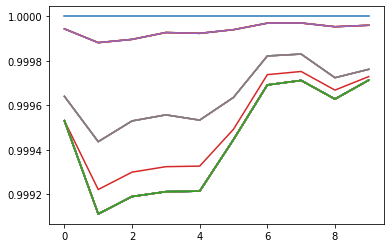

In [7]:
import matplotlib.pyplot as plt

for i in range(33):
    plt.plot(np.arange(10), np.array(grid.voltage_data)[:,i])
    
plt.savefig('voltage')

In [8]:
obss = [env.reset() for env in envs]
for _ in range(5):
    for m in range(len(models)):
        
        # get the current observation from the perspective of this team
        foo = []
        for e in range(nenvs):
            bar = list(envs[m].venv.vec_envs[e].par_env.aec_env.env.state().values())
            for i in range(len(bar)):
                while len(bar[i]) < 19:
                    bar[i] = np.append(bar[i], 0)
            foo += bar

        foo = np.vstack(foo)
        obss[m] = np.vstack(foo)

        action = models[m].predict(obss[m])[0]
        obss[m], reward, done, info = envs[m].step(action)
        print("reward",np.sum(reward))

calling reset...
calling reset...
calling reset...
calling reset...
<class 'supersuit.aec_wrappers.pad_observations'>
<class 'supersuit.aec_wrappers.pad_observations'>
[ 0.07121712 -0.33333334  1.          0.06760956 -0.0855815 ] {'cooling_storage': True, 'dhw_storage': True, 'pv_curtail': True, 'pv_phi': True, 'electrical_storage': True}
[ 0.33333334 -0.33333334 -0.9214563  -0.6440314  -0.7014843 ] {'cooling_storage': True, 'dhw_storage': True, 'pv_curtail': True, 'pv_phi': True, 'electrical_storage': True}
<class 'supersuit.aec_wrappers.pad_observations'>
<class 'supersuit.aec_wrappers.pad_observations'>
[-0.3303543   0.33333334 -0.55927324  0.40079027 -0.6826444 ] {'cooling_storage': True, 'dhw_storage': True, 'pv_curtail': True, 'pv_phi': True, 'electrical_storage': True}
[ 0.06337799  0.03946015 -0.79311067  1.          0.30698416] {'cooling_storage': True, 'dhw_storage': True, 'pv_curtail': True, 'pv_phi': True, 'electrical_storage': True}
reward 0.11376029
<class 'supersuit.aec_